# Project 1

**Note**: if you feel like your Pandas skills need a bit of a touch up, check [this article out](https://levelup.gitconnected.com/20-pandas-functions-for-80-of-your-data-science-tasks-b610c8bfe63c)!

The dataset we're going to be using is one of the most realistic retail time-series datasets you'll find out there because, well, it's actual Walmart data. It was made available for a Kaggle competition that you can check out [here](https://www.kaggle.com/c/m5-forecasting-accuracy).

The original format of the data was in a "wide" format to made it smaller in memory, but that doesn't really work too well with databases and you won't see that very often in the real world. The most notable changes are that I added in a date column to replace the date identifier columns that were previously there, and I made the data smaller by only subsetting to the state of Texas.

**Another note:** If you want to develop and test your code with a smaller dataset (which I'd probably recommend), set `sampled` in the cell below to `True`. All of the tests will still pass if your code is correct!

Let's get into it!

In [1]:
data_dir = '/kaggle/input/project1-data/data'
sampled = True

path_suffix = '' if not sampled else '_sampled'

In [2]:
import pandas as pd
import numpy as np

## Getting our data in the right format

Time-series data has to be collected from some real-world, data-generating process. That means that raw data comes in as a series of observations. Depending on your experience with time-series data, you may be used to data that looks like this:

| Date       | Sales |
|------------|-------|
| 2022-01-01 |  23   |
| 2022-01-02 |  45   |
| 2022-01-03 |  12   |
| 2022-01-04 |  67   |
| 2022-01-05 |  89   |

But, if you're in retail, each of those "sales" probably came in some JSON from some point-of-sale system (i.e. cash register) that probably looked something like this:

```
{
    "timestamp": 2022-01-01 12:34:56,
    "product_id": 5,
    "store_id": 12,
    "category_id": 36,
    ...
}
```

Usually, it's the job of a data engineer to collect all of these records and aggregate them into a nice, tabular format, but it's worth at least having an appreciation for how it's done. So, we're going to start from a mock version of a transactions table.

In [3]:
transactions = pd.read_csv(f'{data_dir}/transactions_data{path_suffix}.csv')

transactions.head()

,date,id,item_id,dept_id,cat_id,store_id,state_id
0,2013-01-01 13:41:03,HOBBIES_1_004_TX_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,TX_1,TX
1,2013-01-01 07:30:52,HOBBIES_1_004_TX_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,TX_1,TX
2,2013-01-01 11:17:38,HOBBIES_1_004_TX_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,TX_1,TX
3,2013-01-01 06:07:58,HOBBIES_1_004_TX_2_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,TX_2,TX
4,2013-01-01 21:51:07,HOBBIES_1_004_TX_2_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,TX_2,TX


In [4]:
transactions.dtypes

date        object
id          object
item_id     object
dept_id     object
cat_id      object
store_id    object
state_id    object
dtype: object

You can see that this is a DataFrame where each row relates to purchases for an individual item. Here's a little data dictionary:

- `date`: the time at which an item was bought, down to the second
- `id`: the product ID. Each of these is an individual item at a specific store.
- `item_id`: this is an identifier for items, but not at the store level. You can use this to find the same item at different stores.
- `dept_id`: department ID. One level up from `item_id` in the hierarchy
- `cat_id`: category ID. One level up from `dept_id` in the hierarchy
- `store_id`: identifies the specific store where the product was bought
- `state_id`: identifies the specific state where the product was bought

`date` is supposed to be a `datetime`-like object, but you can see that when we loaded it from disk, it was loaded in as a string. Let's convert that column to `datetime`.

In [6]:
# QUESTION: Convert this column to a datetime object
transactions['date'] = pd.to_datetime(transactions['date']).dt.normalize()

In [165]:
transactions.dtypes

date        datetime64[ns]
id                  object
item_id             object
dept_id             object
cat_id              object
store_id            object
state_id            object
dtype: object

Our goal is to transform this dataset into one that's easy to analyze and train models on. For this project, our goal is going to be to work at the daily level. So, our first step is to aggregate our transactions data up to the daily level.

To be more specific, this is what we want it to look like:

In [18]:
# This is a hefty table, so just peeking at the first 5 rows
pd.read_csv(f'{data_dir}/sales_data{path_suffix}.csv', nrows=5)


,date,id,item_id,dept_id,cat_id,store_id,state_id,sales
0,2013-01-01,HOBBIES_1_004_TX_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,TX_1,TX,3
1,2013-01-01,HOBBIES_2_075_TX_1_evaluation,HOBBIES_2_075,HOBBIES_2,HOBBIES,TX_1,TX,0
2,2013-01-01,HOUSEHOLD_1_247_TX_1_evaluation,HOUSEHOLD_1_247,HOUSEHOLD_1,HOUSEHOLD,TX_1,TX,0
3,2013-01-01,HOUSEHOLD_1_266_TX_1_evaluation,HOUSEHOLD_1_266,HOUSEHOLD_1,HOUSEHOLD,TX_1,TX,0
4,2013-01-01,FOODS_1_001_TX_1_evaluation,FOODS_1_001,FOODS_1,FOODS,TX_1,TX,0


You can see that the `sales` column is really just a daily count of transactions for that particular `id`.

In the cell below, create a dataframe called `data`, which is the transactions dataframe aggregated to the daily level. It should look like the above, except you won't have zero sales days. Don't worry about order: the below test will handle that!

## Ramona's observations on the data attributes

Looking at the data, I noticed the following characteristics regarding its attributes.

1. `id = item_id +'_' + store_id + '_' + 'evaluation'`.
2. `item_id = dept_id + '_' + item_code`, where `item_code` is a 3-digit number.
3. `dept_id = cat_id + '_' + dept_code`, where `dept_code` is a 1-digit number.
4. `store_id = state_id + '_' + store_code`, where `store_code` is a 1-digit number.

These observations support the dimensional modeling of the data. 

Following these decompositions (Functional Dependencies in correct DB-language), we can infer that it is sufficient to aggregate our data on the `id` attribute only. All the other attributes can be inferred using the transformations outlined above.

In the following code cells I perform the simplest check of these assumptions. 

In [13]:
data_1 = transactions.groupby(['state_id','store_id','cat_id','dept_id','item_id','date'])['id'].transform('count')

len(data_1)

111221

In [43]:
data_2 = transactions.groupby(['item_id']).transform('count')

len(data_2)

111221

In [138]:
data_3 = transactions.groupby(['date', 'id']).transform('count')

len(data_3)

111221

In [141]:
data1 = (transactions.assign(date = lambda df: pd.to_datetime(df['date']).dt.normalize())
                            .assign(sales = 1)
                            .groupby(['date', 'id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], as_index=False)['sales'].sum())


In [142]:
len(data1)

13345

In [143]:
data2 = (transactions.assign(date = lambda df: pd.to_datetime(df['date']).dt.normalize())
                            .assign(sales=1)
                            .groupby(['date', 'id'], as_index=False)['sales'].sum())


In [145]:
len(data2)

13345

In [146]:
data2.head()

,date,id,sales
0,2013-01-01,FOODS_3_714_TX_2_evaluation,10
1,2013-01-01,FOODS_3_714_TX_3_evaluation,12
2,2013-01-01,HOBBIES_1_004_TX_1_evaluation,3
3,2013-01-01,HOBBIES_1_004_TX_2_evaluation,2
4,2013-01-01,HOBBIES_1_004_TX_3_evaluation,1


In [166]:
data = (transactions.assign(sales=1)
            .groupby(['date', 'id'], as_index=False)['sales'].sum())
len(data)

13345

If the cell below runs without error, you did it right!

In [167]:
def test_sales_eq(data):
    assert (
        pd.read_csv(f'{data_dir}/sales_data{path_suffix}.csv', usecols=['date', 'id', 'sales'])
        .assign(date=lambda df: pd.to_datetime(df.date))
        .query('sales != 0')
        .merge(data, on=['date','id'], how='left', suffixes=('_actual', '_predicted'))
        .fillna(0)
        .assign(sales_error=lambda df: (df.sales_actual - df.sales_predicted).abs())
        .sales_error
        .sum() < 1e-6
    ), 'Your version of sales does not match the original sales data.'

    assert (
        pd.read_csv(f'{data_dir}/sales_data{path_suffix}.csv', usecols=['date', 'id', 'sales'])
        .query('sales != 0')
        .shape[0]
    ) == data.shape[0], 'Your dataframe has a different number of rows than the original sales data.'

test_sales_eq(data)

## Optimizing our data

Let's take a look at how our data is being stored in memory.

In [168]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13345 entries, 0 to 13344
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    13345 non-null  datetime64[ns]
 1   id      13345 non-null  object        
 2   sales   13345 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.3 MB


In [169]:
data.dtypes

date     datetime64[ns]
id               object
sales             int64
dtype: object

1.5 GB of data for our purposed is certainly no joke. But how much of that is really necessary?

Most of our data is stored in the least memory efficient format for pandas: strings (objects). Let's fix that.

Hint: check out [this page](https://pandas.pydata.org/docs/user_guide/basics.html#basics-dtypes) of the pandas documentation that talks about data types.

In the below cell, convert the data types of columns to reduce memory usage as much as possible.

In [170]:
def optimize_dataframe(df):
    '''
    Transforms the types of the dataframe for optimal storage.
    '''    
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].astype('category')
        elif df[col].dtype == 'int64':
            df[col] = df[col].astype('int32')
    return df


In [171]:
data = optimize_dataframe(data)

In [172]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13345 entries, 0 to 13344
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    13345 non-null  datetime64[ns]
 1   id      13345 non-null  category      
 2   sales   13345 non-null  int32         
dtypes: category(1), datetime64[ns](1), int32(1)
memory usage: 171.6 KB


On my local machine, loading our original CSV took ~8.7 seconds, and that only took 0.1 seconds. And our data types were maintained! Nice!

In my solution, I got the final DataFrame down to 90.4 MB, which is about 6% of the original size!

While we're at it, it's worth talking about the best way to store this data on disk. If we saved this as a CSV, it wouldn't maintain any of the data type modifications we just made. Pandas offers a bunch of options for saving DataFrames, but here are the two I'd recommend:

- [Parquet](https://pandas.pydata.org/docs/dev/reference/api/pandas.DataFrame.to_parquet.html) has basically become the industry standard for storing tabular data on disk. It's a columnar file format that automatically compresses your data (which it does really well) and will maintain any data types you use in Pandas, with only a couple exceptions.

- [Feather](https://pandas.pydata.org/docs/dev/reference/api/pandas.DataFrame.to_parquet.html) is also a columnar data format, but it optimizes heavily for read speed. Your file size will be much bigger than Parquets, but it's really useful when you need to heavily optimize for data reading.

In [173]:
data.to_parquet('sales_data_checkpoint.parquet')

In [174]:
data = pd.read_parquet('sales_data_checkpoint.parquet')

In [175]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13345 entries, 0 to 13344
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    13345 non-null  datetime64[ns]
 1   id      13345 non-null  category      
 2   sales   13345 non-null  int32         
dtypes: category(1), datetime64[ns](1), int32(1)
memory usage: 171.6 KB


## Finishing up our data pre-processing

There's one last modification we need to make to our data before it's ready to go. The way that we converted transactions into sales was *slightly* problematic because now, when a product doesn't sell it just isn't present in our data, rather than appearing as a zero. 

That's an issue for our forecasting models, so let's fix it!

First, set your index to columns that the DataFrame is distinct on (`date` and `id`).

In [176]:
data = data.set_index(['date', 'id'])

In [177]:
data = data.sort_index()

Now, create a MultiIndex with all combinations of daily dates and `id`s using `pd.MultiIndex.from_product` and use it and `.reindex()` to fill the gaps in your data.

In [178]:
def reindex_dataframe(df, date_level, secondary_level, freq, extra_months):
    '''
    Reindexes a DataFrame according to a date_level (this can be day/month/year).
    The purpose of this is to fill-in all the possible combinations of the index entries
    at the specified date level and the secondary_level.
    Params:
        df: the DataFrame we reindex
        date_level: the level at wich we perform the indexing
        secondary_level: the additional attribute(s) used to create the multilevel index
        freq: the frequency at which the index entries will be generated 
              (as specified in the `date_range` method)
        extra_months: extend the time frame with additional months
    Returns:
        The re-indexed DataFrame.
    '''

    min_date = df.index.get_level_values(date_level).min()
    # Dates don't have to be exact since there will be 1 record per month!
    max_date = df.index.get_level_values(date_level).max() + pd.Timedelta(days=31*extra_months)

    # MS ensures that we get the first date of the month
    dates_to_select = pd.date_range(min_date, max_date, freq=freq) 
    secondary_data = df.index.get_level_values(secondary_level).unique()

    # Get all combinations of our new dates and topics
    index_to_select = pd.MultiIndex.from_product([dates_to_select, secondary_data], 
                                              names=[date_level, secondary_level])

    return df.reindex(index_to_select)

In [179]:
reindexed_data = reindex_dataframe(data,'date', 'id', '1D', 1 )

In [180]:
len(reindexed_data)

22842

Finally, fill the resulting `NaN`s in your dataframe. Hint: it's tempting to use `.groupby().fillna(method='ffill')` (and backfilling), but unfortunately this method is quite slow on grouped data. I'd recommend manually recreating the categorical columns by splitting the `id` column on underscores. This cell could take over a minute to run depending on how you implement it!

In [181]:
data = (
    reindexed_data.reset_index()
    .assign(id=lambda df: df.id.astype(str).values)
    .assign(dept_id=lambda df: df['id'].str.split('_', n=2).str[:2].str.join('_'))
    .fillna(0)
    .set_index(['date', 'id'])
)

In [182]:
def test_sales_eq(data):
    data_copy = (
        data
        .copy()
        .reset_index('id')
        .assign(id=lambda df: df.id.astype(str).values)
    )
    assert (
        pd.read_csv(f'{data_dir}/sales_data{path_suffix}.csv', usecols=['date', 'id', 'sales'])
        .query('id != "FOODS_2_394_TX_3_evaluation"')  # this item is missing in my modified data
        .assign(date=lambda df: pd.to_datetime(df.date))
        .merge(
            data_copy, 
            on=['date', 'id'], 
            how='left', 
            suffixes=('_actual', '_predicted')
        )
        .fillna(0)
        .assign(sales_error=lambda df: (df.sales_actual - df.sales_predicted).abs())
        .sales_error
        .sum() < 1e-6
    ), 'Your version of sales does not match the original sales data.'

test_sales_eq(data)

## Exploring our data

Exploratory data analysis is crucial for building the best models.

Before you start this section, though, I would **highly recommend** that you set the index of your DataFrame to be on both the `date` and `id` field (our DataFrame has one row for each `date`/`id` combo). It's up to you, but it's good practice!

For this section, find 3-5 insights about the data that you feel are helpful for building models. Specifically, we'll be building models at the `date`/`dept_id` level (i.e., a forecast for `FOODS_1` on 2011-02-01, 2011-02-02, etc., a forecast for `HOBBIES_1` on 2011-02-01, 2011-02-02, etc.)

The only required one is an [autocorrelation analysis](https://pandas.pydata.org/docs/reference/api/pandas.plotting.autocorrelation_plot.html). Other than that, some ideas are:

- Looking for seasonal patterns and trends for each department
- Department sales by day of week
- Analyses at a higher level, like the category level

Anything goes! Be creative!

Here's an example of plotting the category-level sales for `FOODS_1` to get you started:

```
(
    data
    .groupby(['date', 'dept_id'])
    .sales
    .sum()
    [:, 'FOODS_1']
    .plot()
)
```

In [183]:
data[['dept_id']].value_counts()

dept_id    
HOUSEHOLD_1    7614
FOODS_1        3807
FOODS_3        3807
HOBBIES_1      3807
HOBBIES_2      3807
Name: count, dtype: int64

## Exploring the trends in the FOODS_1 Department

<Axes: xlabel='date'>

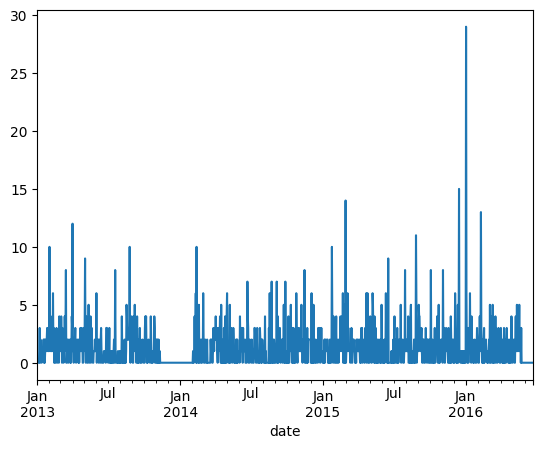

In [195]:
(
    data
    .groupby(['date', 'dept_id'])
    .sales
    .sum()
    [:, 'FOODS_1']
    .plot()
)

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

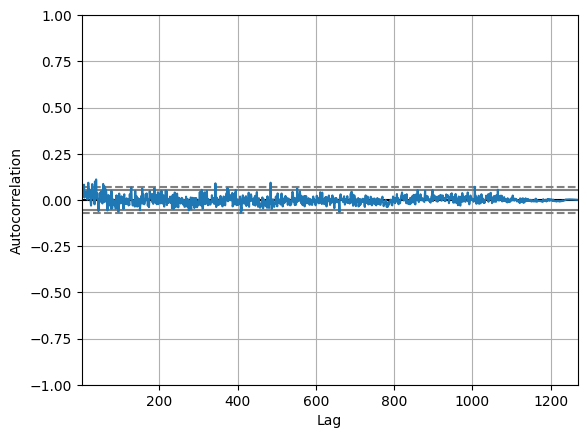

In [196]:
data_plot = (
    data
    .groupby(['date', 'dept_id'])
    .sales
    .sum()
    [:, 'FOODS_1']
)
pd.plotting.autocorrelation_plot(data_plot)

## Exploring the trends in the FOODS_3 Department

<Axes: xlabel='date'>

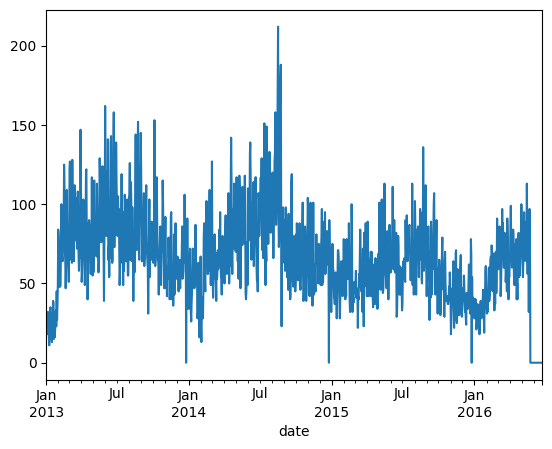

In [197]:
(
    data
    .groupby(['date', 'dept_id'])
    .sales
    .sum()
    [:, 'FOODS_3']
    .plot()
)

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

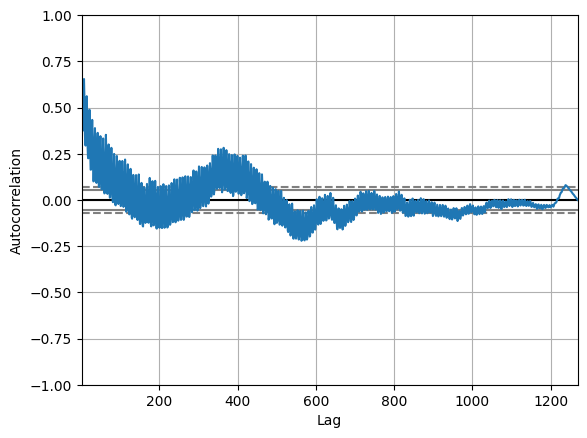

In [198]:
data_plot = (
    data
    .groupby(['date', 'dept_id'])
    .sales
    .sum()
    [:, 'FOODS_3']
)
pd.plotting.autocorrelation_plot(data_plot)

## Exploring the trends in the HOBBIES_1 Department

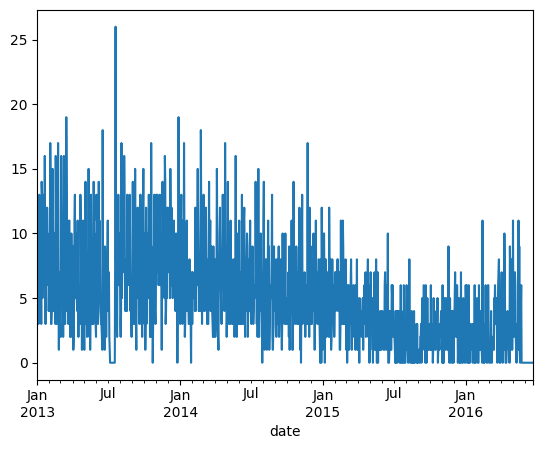

In [199]:
data_plot = (
    data
    .groupby(['date', 'dept_id'])
    .sales
    .sum()
    [:, 'HOBBIES_1']
).plot()


<Axes: xlabel='Lag', ylabel='Autocorrelation'>

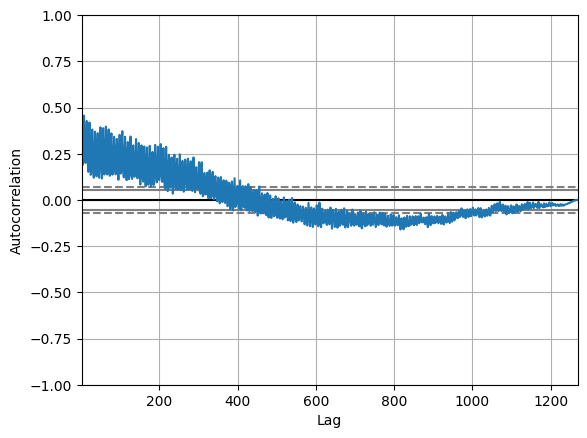

In [200]:
data_plot = (
    data
    .groupby(['date', 'dept_id'])
    .sales
    .sum()
    [:, 'HOBBIES_1']
)
pd.plotting.autocorrelation_plot(data_plot)

## Exploring the trends in the HOBBIES_2 Department

<Axes: xlabel='date'>

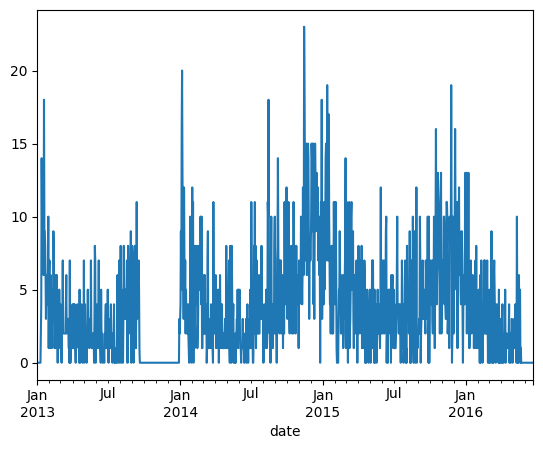

In [205]:
(
    data
    .groupby(['date', 'dept_id'])
    .sales
    .sum()
    [:, 'HOBBIES_2']
    .plot()
)

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

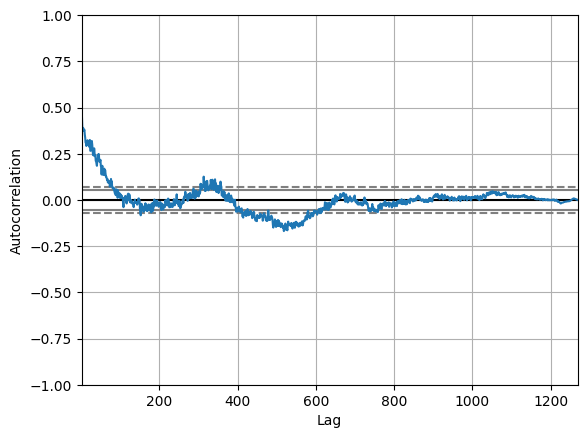

In [206]:
data_plot = (
    data
    .groupby(['date', 'dept_id'])
    .sales
    .sum()
    [:, 'HOBBIES_2']
)
pd.plotting.autocorrelation_plot(data_plot)

## Exploring the trends in the HOUSEHOLD_1 Department

<Axes: xlabel='date'>

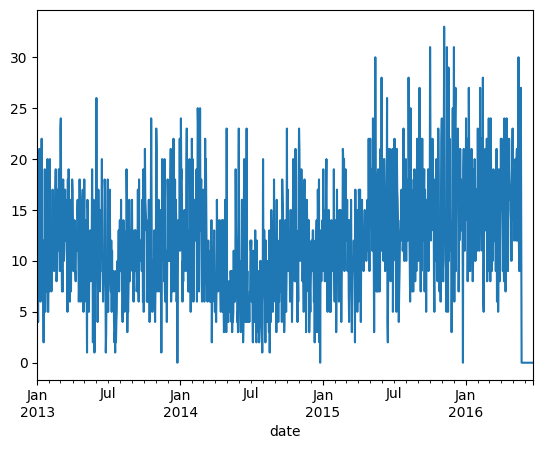

In [186]:
(
    data
    .groupby(['date', 'dept_id'])
    .sales
    .sum()
    [:, 'HOUSEHOLD_1']
    .plot()
)

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

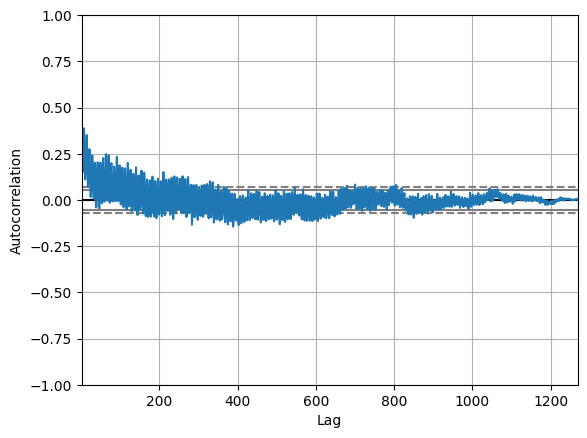

In [207]:
data_plot = (
    data
    .groupby(['date', 'dept_id'])
    .sales
    .sum()
    [:, 'HOUSEHOLD_1']
)
pd.plotting.autocorrelation_plot(data_plot)

## Training some models!

Finally, we can train some models!

We're going to use the [statsforecast](https://github.com/Nixtla/statsforecast) library, since it makes training statistical time-series models really easy. There are other great libraries (like [darts](https://unit8co.github.io/darts/), which is more mature of a package) but I like `statsforecast` a bit more for these models. Eventually, we'll get to training our own models from scratch.

Here's what you need to do:

1. Aggregate sales up to the `date`/`dept_id` level so each date has 7 distinct records (one for each `dept_id`).
2. Convert your aggregated data into the [format that `statsforecast` likes](https://nixtla.github.io/statsforecast/examples/getting_started_short.html).
3. Fit and evaluate some models! This part is made straightforward by `statsforecast` so feel free to fit whatever you want, but focus on models like [this one](https://nixtla.github.io/statsforecast/models.html#arima-family) and [this one](https://nixtla.github.io/statsforecast/models.html#holt-winters-method) since we discussed them. Their documentation has a [quickstart](https://nixtla.github.io/statsforecast/examples/getting_started_short.html) to get going. I provided you with some helper code below to get started.
    - Play around with `ARIMA` and `HoltWinters` and tune them using your intution, then compare them to [`AutoARIMA`](https://nixtla.github.io/statsforecast/models.html#autoarima) and [`AutoETS`](https://nixtla.github.io/statsforecast/models.html#autoets), which do the tuning for you!
4. (If your time permits) try out other libraries! Go try to fit a [Prophet](https://facebook.github.io/prophet/docs/quick_start.html#python-api) model, fit some models using `darts` and see how they compare, etc.

In [189]:
# You'll see a lot of "WARNING: Retrying" outputs if you don't have internet enabled
# This happens because you haven't verified your phone number for your Kaggle profile.
# To do that, you'll need to exit the notebook, go to your profile, go to "account", and verify your phone number.
# Other than that, don't worry about any error outputs you see from this
! pip install statsforecast==1.5.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 kB 3.0 MB/s eta 0:00:00
  Obtaining dependency information for plotly-resampler from https://files.pythonhosted.org/packages/08/1d/87d4ed45c26226630bcb0a205ff006c00645cc68977e22c0f6f16a7f5d2b/plotly_resampler-0.9.1-py3-none-any.whl.metadata
  Obtaining dependency information for fugue>=0.8.1 from https://files.pythonhosted.org/packages/ae/47/d3449da0b9cad85a361bc1003554710a5b612cf60bc2840096e93e5cdbb3/fugue-0.8.7-py3-none-any.whl.metadata
  Obtaining dependency information for triad>=0.9.3 from https://files.pythonhosted.org/packages/19/63/8272d8796118d04c939c7300c5a9f535951be2adfcf099f3fbcc62f0d838/triad-0.9.3-py3-none-any.whl.metadata
  Obtaining dependency information for qpd>=0.4.4 from https://files.pythonhosted.org/packages/56/1f/909bff3b693dc50e0e4318922a93d3047c948acd3011a8c39665cc125d19/qpd-0.4.4-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 7.5 MB/s eta 0:00:00
  Preparing metadat

In [212]:
from statsforecast import StatsForecast
from statsforecast.models import ARIMA, HoltWinters, AutoARIMA, AutoETS
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [191]:
# Aggregate data to date/dept_id level

train_data = data.groupby(['date', 'dept_id']).sales.agg('sum').reset_index()
train_data.head()

,date,dept_id,sales
0,2013-01-01,FOODS_1,0.0
1,2013-01-01,FOODS_3,22.0
2,2013-01-01,HOBBIES_1,6.0
3,2013-01-01,HOBBIES_2,0.0
4,2013-01-01,HOUSEHOLD_1,4.0


In [209]:
train_data[['dept_id']].value_counts()

dept_id    
FOODS_1        1269
FOODS_3        1269
HOBBIES_1      1269
HOBBIES_2      1269
HOUSEHOLD_1    1269
Name: count, dtype: int64

In [216]:
df = train_data.rename(columns={
    'dept_id': 'unique_id',
    'date': 'ds',
    'sales': 'y'
})
train_df = df[df.ds < pd.Timestamp('2016-04-24')]

order = (1, 1, 1)
seasonal_order = (1, 1, 1)
season_length = 7
sf = StatsForecast(
    models=[
        # SARIMAX(order=order, seasonal_order=seasonal_order, season_length=season_length),

        # SARIMA(1, 1, 1)(1, 1, 1),7
        ARIMA(order=order, seasonal_order=seasonal_order, season_length=season_length),
        AutoETS(season_length=season_length),        
        HoltWinters(season_length=season_length),
        AutoARIMA(season_length=season_length),
     ],
    freq='D'
)
sf.fit(train_df)

StatsForecast(models=[ARIMA,AutoETS,HoltWinters,AutoARIMA])

In [218]:
forecast_df = sf.predict(h=28)
forecast_df.tail()


<__array_function__ internals>:200: RuntimeWarning:

invalid value encountered in cast



,ds,ARIMA,AutoETS,HoltWinters,AutoARIMA
unique_id,,,,,
HOUSEHOLD_1,2016-05-17,12.426724,12.687288,12.681387,15.235857
HOUSEHOLD_1,2016-05-18,16.117781,14.123528,14.136603,15.276676
HOUSEHOLD_1,2016-05-19,15.121934,13.722016,13.723376,15.445823
HOUSEHOLD_1,2016-05-20,15.544366,16.856112,16.899557,15.404623
HOUSEHOLD_1,2016-05-21,20.835426,18.752897,18.759912,15.308101


These are `plotly` charts, which are interactive. If you're not familiar, you can:
- Click a series name in the legend (on the right) to activate/deactivate it in the plots
- Hover your mouse over the plots and click + drag to zoom in
- Double click on the plots to zoom back out

In [219]:
sf.plot(df, forecast_df)

In [221]:
sf.plot(df[(df['unique_id'] == 'HOUSEHOLD_1') & (df['ds'] >= pd.Timestamp('2016-04-24'))], forecast_df)

In [227]:
sf.plot(df[(df['unique_id'] == 'FOODS_1') & (df['ds'] > pd.Timestamp('2016-05-30'))], forecast_df)